In [83]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
import copy

In [84]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [85]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


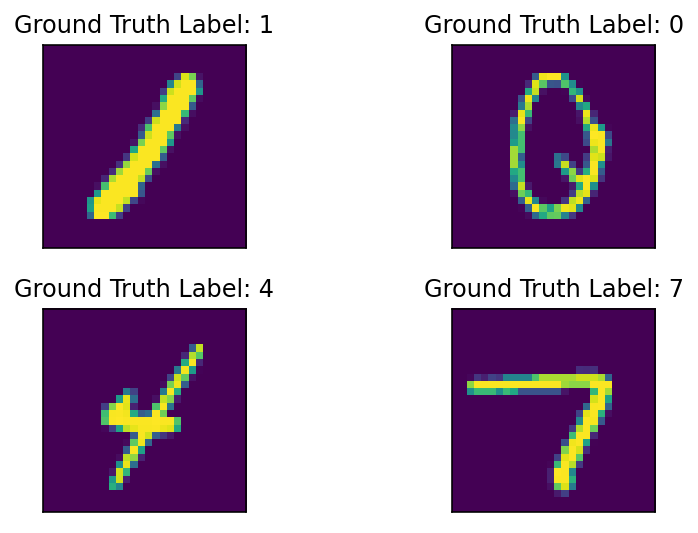

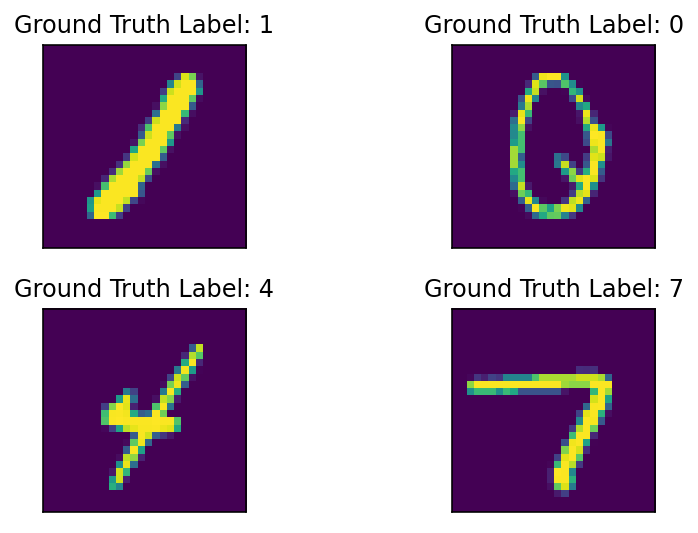

In [86]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0])
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

In [87]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                #conv 1
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
               
                #conv 2 
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                #conv 3 
                nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                
                #conv 4
                nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 
                #conv 5
                nn.Conv2d(in_channels=64, out_channels=80, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
        )
                
               
               

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=80*7*7, out_features=128),          
                nn.ReLU(),
                nn.Dropout(p=0.2), 
                nn.Linear(in_features=128, out_features=10) 
        )

   # Defining the forward pass 
    def forward(self, x):
      x = self.convolutaional_neural_network_layers(x)
      # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
      x = x.view(x.size(0), -1)
      # Then pass it through the linear layer
      x = self.linear_layers(x)
      # The softmax function returns the prob likelihood of getting the input image. 
      # We will see a much graphical demonstration below
      x = F.log_softmax(x, dim=1)
      return x

In [88]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3920, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [89]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [90]:
epochs = 20 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        # Turn off the gradients when performing validation.
        # If we don't turn it off, we will comprise our networks weight entirely
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/20   Training loss: 1.7654   Testing loss: 0.3140   Test accuracy: 0.9056  
Epoch: 2/20   Training loss: 0.2484   Testing loss: 0.1397   Test accuracy: 0.9565  
Epoch: 3/20   Training loss: 0.1448   Testing loss: 0.0939   Test accuracy: 0.9706  
Epoch: 4/20   Training loss: 0.1075   Testing loss: 0.0740   Test accuracy: 0.9762  
Epoch: 5/20   Training loss: 0.0854   Testing loss: 0.0766   Test accuracy: 0.9763  
Epoch: 6/20   Training loss: 0.0729   Testing loss: 0.0557   Test accuracy: 0.9820  
Epoch: 7/20   Training loss: 0.0634   Testing loss: 0.0538   Test accuracy: 0.9819  
Epoch: 8/20   Training loss: 0.0565   Testing loss: 0.0534   Test accuracy: 0.9827  
Epoch: 9/20   Training loss: 0.0492   Testing loss: 0.0447   Test accuracy: 0.9840  
Epoch: 10/20   Training loss: 0.0440   Testing loss: 0.0425   Test accuracy: 0.9869  
Epoch: 11/20   Training loss: 0.0392   Testing loss: 0.0462   Test accuracy: 0.9853  
Epoch: 12/20   Training loss: 0.0357   Testing loss: 0.0418   T

In [91]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_weights2.pth')

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
model_final = copy.deepcopy(model)

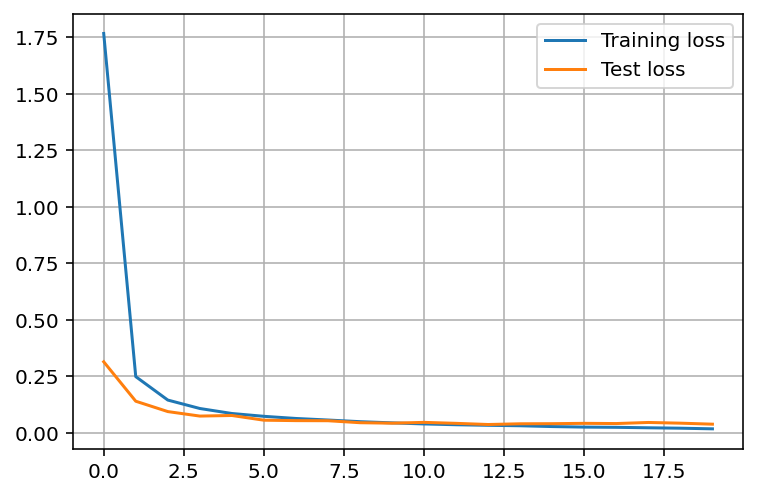

In [94]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [95]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


In [96]:
pip install loss-landscapes

In [97]:
import loss_landscapes
import loss_landscapes.metrics
import copy


In [98]:
# data that the evaluator will use when evaluating loss
x, y = iter(trainloader).__next__()

metric = loss_landscapes.metrics.Loss(criterion, x, y)


In [107]:
STEPS =100
loss_data_fin = loss_landscapes.random_plane(model_final.cpu(), metric,10, STEPS, normalization='filter', deepcopy_model=True)

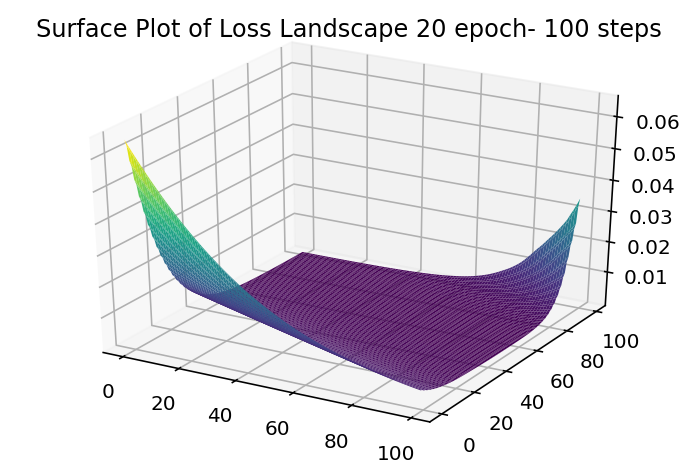

In [110]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape 20 epoch- 100 steps')
fig.show()